### Test N2 from alchemy

#### difference between two different alchemical energies
- Error drastically reduced (-0.5 Ha instead of -3.14 Ha)

- error for vac->H2 not the largest (vac not problem)
- H2->He2 problematic again, Be2->B2 as well
- but integration with simpson rule higher error for vac->N2 because of kink, alchemical potential wrong?
- try difference before integration

In [1]:
import numpy as np
import scipy as sc
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import qml
from matplotlib import pyplot as plt
from IPython.display import display, Markdown


angstrom = 1 / 0.52917721067

In [2]:
def generate_mol(el, d, basis, total_elec, num_elec):
    mol = pyscf.gto.Mole()
    mol.atom = f'{el} 0 0 0; {el} 0 0 {d}'
    mol.basis = basis
    mol.charge = total_elec - num_elec
    mol.verbose = 0
    mol.build()
    return(mol)

def pyscf_APDFT(mol, total_elec):
    method = "HF"
    if method not in ["CCSD", "HF"]:
        raise NotImplementedError("Method %s not supported." % method)

    deltaZ = [-mol.charge/2, -mol.charge/2]
    includeonly = np.arange(len(mol.atom_coords()))

    def add_qmmm(calc, mol, deltaZ):
        mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)

        mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

        return mf

    if method == "HF":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        dm1_ao = calc.make_rdm1()
        total_energy = calc.e_tot
    if method == "CCSD":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        mycc = pyscf.cc.CCSD(calc).run()
        dm1 = mycc.make_rdm1()
        dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
        total_energy = mycc.e_tot

    # GRIDLESS, as things should be ############################
    # Total energy of SCF run

#     print("TOTAL_ENERGY", total_energy)

    # Electronic EPN from electron density
    alchemical_potentials = []
    for site in includeonly:
        mol.set_rinv_orig_(mol.atom_coords()[site])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())

    # energy of HOMO and LUMO
    nocc = int((total_elec - mol.charge)/2)
    e_homo = calc.mo_energy[nocc-1]
    e_lumo = calc.mo_energy[nocc]

    return(alchemical_potentials, e_homo, e_lumo, calc.energy_nuc())

def sample_path(num_elecs, element, distance, basis, total_nelec):
    alchemical_potentials = []
    e_homos = []
    e_lumos = []
    e_nucs = []

    for num_elec in num_elecs:
        mol = generate_mol(element, distance, basis, total_nelec, num_elec)
        alchpot, ehomo, elumo, enuc = pyscf_APDFT(mol, total_nelec)
        alchemical_potentials.append(alchpot)
        e_homos.append(ehomo)
        e_lumos.append(elumo)
        e_nucs.append(enuc)
    alchemical_potentials = -1*np.array(alchemical_potentials)
    e_homos = np.array(e_homos)
    e_lumos = np.array(e_lumos)
    e_nucs = np.array(e_nucs)
    return(alchemical_potentials, e_homos, e_lumos, e_nucs)

def get_energy(lam_vals, alchemical_potentials, nuc_rep, e_homos, dZ, dN, int_rule = 'simp'):
    if int_rule == 'simp':
        mu_I = sc.integrate.simps(alchemical_potentials, lam_vals)
    elif int_rule == 'trapz':
        mu_I = np.trapz(alchemical_potentials, lam_vals)
    e_homo = np.trapz(e_homos, lam_vals)
    
    return(2*mu_I * dZ + e_homo*dN + nuc_rep)

def get_lam_vals(num_elecs):
    return(1/(num_elecs[-1]-num_elecs[0])*num_elecs - num_elecs[0]/(num_elecs[-1]-num_elecs[0]))


### Referenz calculations:  H$_2$, N$_2$

In [3]:
def ref_hf(el, d, basis = 'def2-qzvp'):
    mol = pyscf.gto.Mole()
    mol.atom = f'{el} 0 0 0; {el} 0 0 {d}'
    mol.basis = basis
    mol.build()
    m = pyscf.scf.RHF(mol)
    m.kernel()
    e_ref_qzvp = m.e_tot
    return(e_ref_qzvp)

def get_ref_dict(d, basis = 'def2-qzvp'):
    eref_dict = {'vac':0, 'H2':0, 'He2':0, 'Li2':0, 'Be2':0, 'B2':0, 'C2':0, 'N2':0}

    for k in eref_dict.keys():
        if k != 'vac':
            eref_dict[k] = ref_hf(k.strip('2'), d, basis = basis)
    return(eref_dict)

In [4]:
eref_d1p5 = get_ref_dict(1.5)

converged SCF energy = -1.00484447618229
converged SCF energy = -5.70366878184579
converged SCF energy = -14.7683554342198
converged SCF energy = -28.9802573563847
converged SCF energy = -49.0345264861146
converged SCF energy = -75.3468412931265
converged SCF energy = -108.711062429174


In [5]:
eref_d5 = get_ref_dict(5.0)

converged SCF energy = -0.770571790838804
converged SCF energy = -5.72324969844536
converged SCF energy = -14.8311018525141
converged SCF energy = -29.1458870618473
converged SCF energy = -48.9305101404032
converged SCF energy = -74.9288689161556
converged SCF energy = -107.866422116249


#### $\Delta$ H$_2$ $\rightarrow$ N$_2$, d = 1.5 and d = 5.0

In [6]:
e_H2N_dist = {1.5:0, 5.0:0}
alch_1 = []
for d in e_H2N_dist.keys():
    element = 'N'
    distance = d
    basis = 'def2-qzvp'
    total_nelec = 14
    num_elecs = np.array([2, 4, 6, 8, 10, 12, 14])
    lam_vals = 1/(num_elecs[-1]-num_elecs[0])*num_elecs - num_elecs[0]/(num_elecs[-1]-num_elecs[0])
    alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path(num_elecs, element, distance, basis, total_nelec)
    e_H2N_simp = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, 6, 12) - e_nucs[0]
    e_H2N_trapz = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, 6, 12, 'trapz') - e_nucs[0]
    e_H2N_dist[d] = e_H2N_simp
    
    alch_1.append(alchemical_potentials[:,0])

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


In [7]:
d_e_H2N = e_H2N_dist[1.5] - e_H2N_dist[5.0]
d_eref_H2N = (eref_d1p5['N2'] - eref_d1p5['H2']) - (eref_d5['N2'] - eref_d5['H2'])

print('integration by simpsons rule')
display(Markdown(r'$\Delta \Delta E$ (H$_2$ $\rightarrow$ N$_2$) = ' + str(d_e_H2N)))
display(Markdown(r'$\Delta \Delta E_{\rm{ref}}$ = ' + str(d_eref_H2N)))
display(Markdown(r'$\Delta \Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta \Delta E_{\rm{ref}}$ = ' + str(d_e_H2N-d_eref_H2N)))

integration by simpsons rule


$\Delta \Delta E$ (H$_2$ $\rightarrow$ N$_2$) = -1.052824442228939

$\Delta \Delta E_{\rm{ref}}$ = -0.6103676275809278

$\Delta \Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta \Delta E_{\rm{ref}}$ = -0.44245681464801123

### vac $\rightarrow$ N$_2$, d = 1.5 and d = 5.0

10 ang unstable

In [8]:
e_vac2N_dist = {1.5:0, 5.0:0}
alch2 = []
for d in e_vac2N_dist.keys():
    element = 'N'
    distance = d
    basis = 'def2-qzvp'
    total_nelec = 14
    num_elecs = np.array([2, 4, 6, 8, 10, 12, 14])
    alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path(num_elecs, element, distance, basis, total_nelec)
    
    lam_vals = 1/num_elecs[-1]*num_elecs
    lam_vals = np.concatenate((np.array([0.0]), lam_vals))
    alchemical_potentials = np.concatenate((np.array([[0.0, 0.0]]), alchemical_potentials))
    e_homos = np.concatenate((np.array([0.0]), e_homos))
    e_lumos = np.concatenate((np.array([0.0]), e_lumos))
    
    e_vac2N_simp = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, 7, 14)
    e_vac2N_dist[d] = e_vac2N_simp
    
    alch2.append(alchemical_potentials[:,0])

In [9]:
d_e_vac2N = e_vac2N_dist[1.5] - e_vac2N_dist[5.0]
d_eref_N = eref_d1p5['N2'] - eref_d5['N2']

print('integration by simpsons rule')
display(Markdown(r'$\Delta \Delta E$ (vac $\rightarrow$ N$_2$) = ' + str(d_e_vac2N)))
display(Markdown(r'$\Delta \Delta E_{\rm{ref}}$ = ' + str(d_eref_N)))
display(Markdown(r'$\Delta \Delta E (vac \rightarrow \rm{N}_2)- \Delta \Delta E_{\rm{ref}}$ = ' + str(d_e_vac2N-d_eref_N)))

integration by simpsons rule


$\Delta \Delta E$ (vac $\rightarrow$ N$_2$) = -1.3750937126920206

$\Delta \Delta E_{\rm{ref}}$ = -0.8446403129244118

$\Delta \Delta E (vac \rightarrow \rm{N}_2)- \Delta \Delta E_{\rm{ref}}$ = -0.5304533997676089

#### Why error higher for vac->N2 if simpsons rules is used
because of kink at potential for H2 when starting at vacuum (alchemical potential would need to be higher to avoid kink)

In [10]:
alch2

[array([  0.        ,  -1.29426202,  -4.09848617,  -6.898463  ,
         -9.87442425, -13.07290408, -16.71126325, -20.63771543]),
 array([  0.        ,  -0.98746611,  -3.58556127,  -6.02613942,
         -8.92879064, -11.88496887, -15.20801578, -18.88826915])]

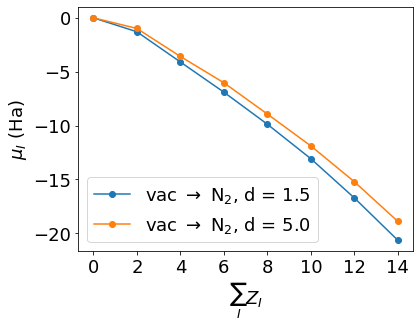

In [11]:
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,1)

# ax.plot(np.arange(2, 16, 2), alch_1[0], '-o', label = r'H$_2$ $\rightarrow$ N$_2$, d = 1.5')
# ax.plot(np.arange(2, 16, 2),alch_1[1], '-o', label = r'H$_2$ $\rightarrow$ N$_2$, d = 5.0')
ax.plot(np.arange(0, 16, 2),alch2[0], '-o', label = r'vac $\rightarrow$ N$_2$, d = 1.5')
ax.plot(np.arange(0, 16, 2),alch2[1], '-o', label = r'vac $\rightarrow$ N$_2$, d = 5.0')
ax.set_xlabel(r'$\sum_I Z_I$')
ax.set_ylabel(r'$\mu_I$ (Ha)')
ax.set_xticks(np.arange(0, 16, 2))
ax.legend()
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/vacuum_reference/kink_mu_vactoN2.png', bbox_inches='tight')

#### difference for adjacent pairs

In [12]:
element = 'N'
distance = 1.5
basis = 'def2-qzvp'
total_nelec = 14
num_elecs = np.array([0,2])
pairs = {'vactoH2':[], 'H2toHe2':[], 'He2toLi2':[], 'Li2toBe2':[], 'Be2toB2':[], 'B2toC2':[], 'C2toN2':[]}
alchs = []
ehs = []
for k in pairs.keys():
    if k == 'vactoH2':
        alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path([num_elecs[-1]], element, distance, basis, total_nelec)
        alchemical_potentials = np.concatenate((np.array([[0.0, 0.0]]), alchemical_potentials))
        e_homos = np.concatenate((np.array([0]), e_homos))
        e_lumos = np.concatenate((np.array([0]), e_lumos))
        e_nucs = np.concatenate((np.array([0.0]), e_nucs))     
    else:
        alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path(num_elecs, element, distance, basis, total_nelec)
    alchs.append(alchemical_potentials)
    ehs.append(e_homos)
    dN = num_elecs[-1] - num_elecs[0]
    dZ = dN/2
    lam_vals = get_lam_vals(num_elecs)
    e_X2toY2_simp = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, dZ, dN) - e_nucs[0]
    pairs[k].append(e_X2toY2_simp)
    num_elecs = num_elecs + 2 #raise to get correct number for next pair of diatomics

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


In [13]:
element = 'N'
distance = 5.0
basis = 'def2-qzvp'
total_nelec = 14
num_elecs = np.array([0,2])
pairs5 = {'vactoH2':[], 'H2toHe2':[], 'He2toLi2':[], 'Li2toBe2':[], 'Be2toB2':[], 'B2toC2':[], 'C2toN2':[]}
alchs = []
ehs = []
for k in pairs5.keys():
    if k == 'vactoH2':
        alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path([num_elecs[-1]], element, distance, basis, total_nelec)
        alchemical_potentials = np.concatenate((np.array([[0.0, 0.0]]), alchemical_potentials))
        e_homos = np.concatenate((np.array([0]), e_homos))
        e_lumos = np.concatenate((np.array([0]), e_lumos))
        e_nucs = np.concatenate((np.array([0.0]), e_nucs))     
    else:
        alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path(num_elecs, element, distance, basis, total_nelec)
    alchs.append(alchemical_potentials)
    ehs.append(e_homos)
    dN = num_elecs[-1] - num_elecs[0]
    dZ = dN/2
    lam_vals = get_lam_vals(num_elecs)
    e_X2toY2_simp = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, dZ, dN) - e_nucs[0]
    pairs5[k].append(e_X2toY2_simp)
    num_elecs = num_elecs + 2 #raise to get correct number for next pair of diatomics

In [14]:
dE_vactoN2_dict = dict.fromkeys(pairs.keys())
for k in pairs.keys():
    dE_vactoN2_dict[k] = []
    dE_vactoN2_dict[k].append(pairs[k][0] - pairs5[k][0])

In [15]:
# add reference delta
for k in dE_vactoN2_dict.keys():
    diatomics = k.split('to')
    dE_ref1p5 = eref_d1p5[diatomics[1]]-eref_d1p5[diatomics[0]]
    dE_ref5 = eref_d5[diatomics[1]]-eref_d5[diatomics[0]]
    
    dE_vactoN2_dict[k].append(dE_ref1p5-dE_ref5)
    
    dE_vactoN2_dict[k].append(dE_vactoN2_dict[k][0] - dE_vactoN2_dict[k][1])

In [16]:
stepwise_i = []
for k in dE_vactoN2_dict.keys():
    stepwise_i.append(dE_vactoN2_dict[k][0])
stepwise_i = np.array(stepwise_i)

In [17]:
stepwise_i[1:].sum()

-1.1372070602093434

Text(0, 0.5, 'Error $\\Delta E$ (Ha)')

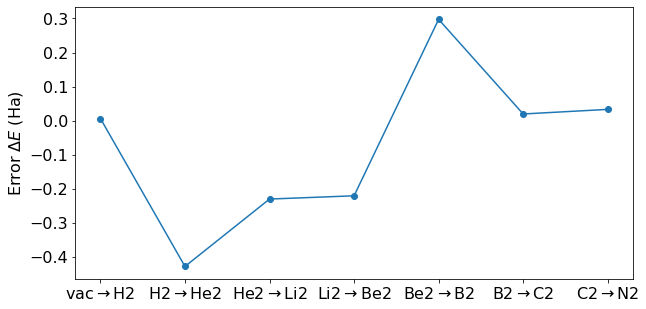

In [18]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
x = np.arange(1, 15, 2)
dE = []
for k in dE_vactoN2_dict.keys():
    dE.append(dE_vactoN2_dict[k][2])
ax.plot(x, dE, '-o')
ax.set_xticks(x)
xstring = [r'vac$\rightarrow$H2', r'H2$\rightarrow$He2', r'He2$\rightarrow$Li2', r'Li2$\rightarrow$Be2', r'Be2$\rightarrow$B2', r'B2$\rightarrow$C2', r'C2$\rightarrow$N2']
ax.set_xticklabels(xstring, fontsize=16)
ax.set_ylabel(r'Error $\Delta E$ (Ha)')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/vacuum_reference/error_stepwise_intg_N2_diff.png', bbox_inches='tight')

- error for vac->H2 not the largest
- H2->He2 problematic again, Be2->B2 as well